<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/master/ResNet_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/2020 Kaggle Study/data/train.npy' train.npy

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
warnings.filterwarnings("ignore")
# style 설정
plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 데이터 받아오기

In [0]:
#train = np.load('train.npy')
train = np.load('train_add.npy')

# 데이터 만들기

In [3]:
train.shape

(76345, 40, 40, 15)

In [0]:
def cutoff(data):
    index = 0
    rain_index = []
    for file in data:
        target= file[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        if (cutoff_labels > 0).sum() < 50:
            index = index + 1
            continue
        rain_index.append(index)
        index = index + 1
    return data[rain_index], rain_index

def re_landtype(data):
    rain = data[:,:,:,9].reshape(-1)
    rain = rain//100
    #data[data[:,:,:,9] == 0] = 0 #Ocean
    rain[rain == 1] = 1 #land
    rain[rain == 2] = 0.5 #costal
    rain[rain == 3] = 0.2 #in land water
    data[:,:,:,9] = rain.reshape(-1,40,40)
    return data
    
def augment_data(data):# 원래, 90회전.T(2배)
    rotate = np.zeros([data.shape[0]*2,data.shape[1],data.shape[2],data.shape[3]])
    ch_num = data.shape[3]
    data_len = data.shape[0]
    rotate[:data_len,:,:,:] = data
    #rotate[data_len : data_len * 2,:,:,:] = np.rot90(rotate[:data_len,:,:,:], axes = (1,2))
    rotate[data_len:,:,:,:] = np.transpose(rotate[: data_len,:,:,:], axes = (0,1,2,3))
    return rotate

def select_ch(data,ch_list = [0,1,2,3,4,5,6,7,8,9,14]):#9: land_type, 14: precipitation
    return(data[:,:,:,ch_list])

In [0]:
train = select_ch(train)
train, rain_index = cutoff(train)
train = re_landtype(train)
train = augment_data(train)

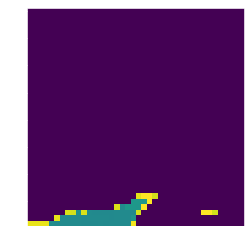

In [65]:
plt.imshow(train[22,:,:,9])

#모델 만들기

In [0]:
def create_model():
    inputs=Input((40,40,10))
    ###cnn
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
model = create_model()

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

## 데이터 제네레이터 만들기

In [8]:
gc.collect()

29

In [0]:
def augment_generator(train):
    rotate = np.zeros([train.shape[0]*4,40,40,train.shape[3]])
    ch_num = train.shape[3]
    train_len = train.shape[0]
    rotate[:train_len,:,:,:] = train
    rotate[train_len : train_len * 2,:,:,:] = np.rot90(rotate[:train_len,:,:,:], axes = (1,2))
    rotate[train_len * 2 : train_len * 3,:,:,:] = np.rot90(rotate[train_len : train_len * 2,:,:,:], axes = (1,2))
    rotate[train_len * 3 : train_len * 4,:,:,:] = np.rot90(rotate[train_len * 2 : train_len * 3,:,:,:], axes = (1,2))
    return rotate

class MultiOutputDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def flow(self,
             x,
             y,
             batch_size=None,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        for flowx, flowy in super().flow(x,y, batch_size= batch_size, shuffle = shuffle):
            flowx = augment_generator(flowx)
            flowy = augment_generator(flowy)
            yield (flowx, flowy)

In [10]:
gc.collect()

569

In [0]:
from sklearn.model_selection import KFold
def train_model(x_data, y_data, k, s):
    k_fold = KFold(n_splits=k, shuffle=True, random_state=7777)
    model_number = 0
    for train_idx, val_idx in k_fold.split(x_data):
        if model_number == s:
            x_train, y_train = x_data[train_idx], y_data[train_idx]
            x_val, y_val = x_data[val_idx], y_data[val_idx]
            model = create_model()
            model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])
            callbacks_list = [
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    patience=3,
                    factor=0.8
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    filepath = '/content/drive/My Drive/2020 Kaggle Study/deagwon/best_model'+str(model_number)+'.h5',
                    monitor='val_score',
                    save_best_only=True
                )
            ]

            datagen = MultiOutputDataGenerator()
            datagen.fit(x_train)
            batch_size = 32
            model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=50,
                      steps_per_epoch = len(x_train) // batch_size,
                      validation_data=(x_val, y_val), callbacks=callbacks_list)
            model.save(f'/content/drive/My Drive/2020 Kaggle Study/deagwon/model_trainonly_{model_number}.h5')
            break##### 일단은 한 폴드만 학습
        model_number+=1

In [0]:
from tensorflow.keras.models import load_model, Model
k = 10
models = []
train_model(train[:,:,:,:-1], train[:,:,:,-1].reshape(-1,40,40,1), k=k, s=4)

Epoch 1/50
1668/1730 [===========================>..] - ETA: 21s - loss: 5.1740 - maeOverFscore_keras: 2.1715 - fscore_keras: 0.6999

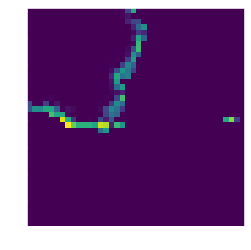

In [37]:
plt.imshow(model.predict(train[8,:,:,:10].reshape(1,40,40,10)).reshape(40,40))

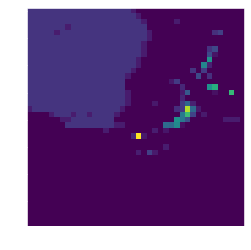

In [40]:
plt.imshow(train[8,:,:,10].reshape(40,40))

In [0]:
model.save('model.h5')

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아서 X_test에 저장하기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_submit = test_submit[:,:,:,:10]
del test_submit
gc.collect()
pred = model.predict(test_submit)

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_landtype.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_landtype.csv '/content/drive/My Drive/2020 Kaggle Study/submission'